## Pre-requirements

In [338]:
#Install dependencies

#AWS python sdk
%pip install -U awscli
%pip install -U boto3

#Langchain
%pip install -U langchain langchain_community langchain_aws
%pip install -U langgraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 125.9 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.35.76
    Uninstalling botocore-1.35.76:
      Successfully uninstalled botocore-1.35.76
  Attempting uninstall: awscli
    Found existing installation: awscli 1.36.17
    Uninstalling awscli-1.36.17:
      Successfully uninstalled awscli-1.36.17
Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: boto3
    Found existing installation: boto3 1.35.76
    Uninstalling boto3-1.35.76:
      Successfully uninstalled boto3-1.35.76
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 123.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langch

In [214]:
# Initialize AWS SDK

import json
import boto3
from botocore.config import Config

session = boto3.Session()

bedrock_client = session.client(
    service_name='bedrock-runtime',
    config=Config(
        read_timeout=3600,
        connect_timeout=3600,
        retries={"max_attempts": 0}
    )
)

from langchain_aws.chat_models import ChatBedrockConverse
from langchain_core.messages import HumanMessage, SystemMessage

bedrock_chat_model = "anthropic.claude-3-sonnet-20240229-v1:0"
#bedrock_chat_model = "amazon.nova-pro-v1:0"
#bedrock_chat_model = "amazon.nova-lite-v1:0"
#bedrock_chat_model = "amazon.nova-micro-v1:0"

bedrock_chat = ChatBedrockConverse(
    client=bedrock_client,
    model_id=bedrock_chat_model,
    temperature=0.3,
    max_tokens=4096
)

session

Session(region_name='us-east-1')

## LED light Prompt Test

In [247]:
LEDCMD_SYSTEM_MSG = """
You are an helpful AI light art designer that creating media art using LED lights for humans.

The human request in <query> tag.
The number LED lights is in <num_of_leds> and, the description of the pattern of led lights is in <description> tag.

You can turn on LED lights by specifying a color expressed in RGB(red, green, blue).
And also you can turn off LED lights for setting black color, represented [0,0,0].
If the state of the LED is specified, it remains in state until it is changed again. 
You can maintain the state by specifying a sleep time.

COMMAND GENERATION CRITERIA:
- You have to create list of commands which formatted by JSON Array.
- The command lists are executed sequentialy.
- If 'repeat' command sets true, entire command list are repeated infinitely.

COMMAND DEFINITIONS:
- The indicator of LEDs starts at 0, and you can use the following command to specify the state of the LED.
- There are 3 of commands, 'set', 'sleep', 'repeat'. this commands represented in JSON format.
- The 'set' command changes color of LED lights. 
    - Change the color of the LED between 'led_id_from' and 'led_id_to'. 
    - 'color' means the value of [red, green, blue], and each color has a value between 0 and 255.
- The 'sleep' command allows how much time stayed current color pattern. 
    - 'milis' means how long you have to wait in miliseconds
- The 'repeat' command sets whether to repeat the entire list of commands.
- Commands for setting colors are sequentially accumulated. 
    - For example, if you set red for numbers 1 and 2 and yellow for numbers 2 and 3, red is finally displayed at number 1 and yellow in numbers 2 and 3.    

CONSTRAINTS:
- If you want to show the color, you must use the 'sleep' command for as long as you want.
- If commands list don't have sleep, please set 1000 miliseconds sleep by default.

COMMAND EXAMPLES:
<commands>
    <set>
        {{
            "cmd": "set",
            "led_id_from": int,
            "led_id_to": int,
            "color": [int, int, int]
        }}
    </set>
    <sleep>
        {{
            "cmd": "sleep",
            "milis": int
        }}
    </sleep>
    <repeat>
        {{
            "cmd": "repeat",
            "repeat": boolean
        }}
    </repeat>
</commands>

EXAMPLES:
Here are 2 of example of query and commands.
<example>
    <query>
        <num_of_leds>3</num_of_leds>
        <description>Blink all LEDS like as white star</description>
    </query>
    </command>
        [
            {{ "cmd": "sleep", "milis": 3000 }},
            {{ "cmd" : "set" , "led_id_from": 0, "led_id_to": 2, "color": [255, 255, 255] }},
            {{ "cmd": "sleep", "milis": 3000 }},
            {{ "cmd" : "set" , "led_id_from": 0, "led_id_to": 2, "color": [0, 0, 0] }}
        ]
    </command>
</example>
<example>
    <query>
        <num_of_leds>5</num_of_leds>
        <description>Move red light left to right once</description>
    </query>
    </command>
        [
            {{ "cmd" : "set" , "led_id_from": 0, "led_id_to": 4, "color": [0, 0, 0] }},
            {{ "cmd" : "set" , "led_id_from": 0, "led_id_to": 0, "color": [255, 0, 0] }},
            {{ "cmd": "sleep", "milis": 1000 }},
            {{ "cmd" : "set" , "led_id_from": 0, "led_id_to": 4, "color": [0, 0, 0] }},
            {{ "cmd" : "set" , "led_id_from": 1, "led_id_to": 1, "color": [255, 0, 0] }},
            {{ "cmd": "sleep", "milis": 1000 }},
            {{ "cmd" : "set" , "led_id_from": 0, "led_id_to": 4, "color": [0, 0, 0] }},
            {{ "cmd" : "set" , "led_id_from": 2, "led_id_to": 2, "color": [255, 0, 0] }},
            {{ "cmd": "sleep", "milis": 1000 }},
            {{ "cmd" : "set" , "led_id_from": 0, "led_id_to": 4, "color": [0, 0, 0] }},
            {{ "cmd" : "set" , "led_id_from": 3, "led_id_to": 3, "color": [255, 0, 0] }},
            {{ "cmd": "sleep", "milis": 1000 }},
            {{ "cmd" : "set" , "led_id_from": 0, "led_id_to": 4, "color": [0, 0, 0] }},
            {{ "cmd" : "set" , "led_id_from": 4, "led_id_to": 4, "color": [255, 0, 0] }},
            {{ "cmd": "sleep", "milis": 1000 }},
            {{ "cmd" : "set" , "led_id_from": 0, "led_id_to": 2, "color": [0, 0, 0] }},
            {{ "cmd": "repeat", "repeat": false }}
        ]
    </command>
</example>
""".strip()

LEDCMD_HUMAN_QUERY="""
Query:
<query>
    <num_of_leds>{num_of_leds}</num_of_leds>
    <description>{query}</description>
</query>

Commands:
""".strip()

In [122]:
from langchain_aws import ChatBedrock
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate

template = ChatPromptTemplate.from_messages([
    ("system", LEDCMD_SYSTEM_MSG),
    ("human",LEDCMD_HUMAN_QUERY),
])

In [210]:
num_of_leds = 3
query = "blink twice like a star"

messages = template.format_messages(num_of_leds=num_of_leds, query=query)

In [211]:
print(messages[1].content)

Query:
<query>
    <num_of_leds>3</num_of_leds>
    <description>blink twice like a star</description>
</query>

Commands:


In [215]:
ai_msg = bedrock_chat.invoke(messages)

In [216]:
print(ai_msg.content)

Here are the commands to blink 3 LEDs twice like a star:

[
  { "cmd": "sleep", "milis": 1000 },
  { "cmd": "set", "led_id_from": 0, "led_id_to": 2, "color": [255, 255, 255] },
  { "cmd": "sleep", "milis": 1000 },
  { "cmd": "set", "led_id_from": 0, "led_id_to": 2, "color": [0, 0, 0] },
  { "cmd": "sleep", "milis": 1000 },
  { "cmd": "set", "led_id_from": 0, "led_id_to": 2, "color": [255, 255, 255] },
  { "cmd": "sleep", "milis": 1000 },
  { "cmd": "set", "led_id_from": 0, "led_id_to": 2, "color": [0, 0, 0] },
  { "cmd": "repeat", "repeat": false }
]


In [217]:
from typing import List, Union
from pydantic import BaseModel

# 출력 구조를 정의하는 TypedDict 클래스들
class SetCommand(BaseModel):
    """The 'set' command changes color of LED lights. Change the color of the LED between 'led_id_from' and 'led_id_to'. 'color' means the value of [red, green, blue], and each color has a value between 0 and 255."""
    cmd: str  # "set"
    led_id_from: int
    led_id_to: int
    color: List[int]

class SleepCommand(BaseModel):
    """The 'sleep' command allows how much time waited. 'milis' means how long you have to wait in miliseconds"""
    cmd: str  # "sleep"
    milis: int

class RepeatCommand(BaseModel):
    """The 'repeat' command sets whether to repeat the entire list of commands. This command can only be used once at the end of the entire command list, and is ignored if defined in the middle."""
    cmd: str  # "repeat"
    repeat: bool

# 전체 명령 리스트의 타입 정의
class LedCommandList(BaseModel):
    """A super set of LED command lists."""
    commands: List[Union[SetCommand, SleepCommand, RepeatCommand]]

In [225]:
num_of_leds = 30
query = "Exciting christmas party with Santa Claus. Santa Claus, dressed in red, walks in while dancing with a green bag. Exciting music and lights continue throughout the party. It would be nice if the color changes slightly and shakes."

# num_of_leds = 3
# query = "blink twice like a star"

chain = template | bedrock_chat.with_structured_output(LedCommandList)
response = chain.invoke({"num_of_leds":num_of_leds, "query": query})

In [226]:
pprint(response.commands)

[SetCommand(cmd='set', led_id_from=0, led_id_to=29, color=[0, 0, 0]),
 SetCommand(cmd='set', led_id_from=0, led_id_to=4, color=[255, 0, 0]),
 SleepCommand(cmd='sleep', milis=500),
 SetCommand(cmd='set', led_id_from=5, led_id_to=9, color=[255, 0, 0]),
 SleepCommand(cmd='sleep', milis=500),
 SetCommand(cmd='set', led_id_from=10, led_id_to=14, color=[255, 0, 0]),
 SleepCommand(cmd='sleep', milis=500),
 SetCommand(cmd='set', led_id_from=15, led_id_to=19, color=[0, 255, 0]),
 SleepCommand(cmd='sleep', milis=500),
 SetCommand(cmd='set', led_id_from=20, led_id_to=24, color=[0, 255, 0]),
 SleepCommand(cmd='sleep', milis=500),
 SetCommand(cmd='set', led_id_from=25, led_id_to=29, color=[0, 255, 0]),
 SleepCommand(cmd='sleep', milis=1000),
 SetCommand(cmd='set', led_id_from=0, led_id_to=29, color=[255, 165, 0]),
 SleepCommand(cmd='sleep', milis=500),
 SetCommand(cmd='set', led_id_from=0, led_id_to=29, color=[255, 0, 0]),
 SleepCommand(cmd='sleep', milis=500),
 SetCommand(cmd='set', led_id_from=0,

In [227]:
response.model_dump_json()

'{"commands":[{"cmd":"set","led_id_from":0,"led_id_to":29,"color":[0,0,0]},{"cmd":"set","led_id_from":0,"led_id_to":4,"color":[255,0,0]},{"cmd":"sleep","milis":500},{"cmd":"set","led_id_from":5,"led_id_to":9,"color":[255,0,0]},{"cmd":"sleep","milis":500},{"cmd":"set","led_id_from":10,"led_id_to":14,"color":[255,0,0]},{"cmd":"sleep","milis":500},{"cmd":"set","led_id_from":15,"led_id_to":19,"color":[0,255,0]},{"cmd":"sleep","milis":500},{"cmd":"set","led_id_from":20,"led_id_to":24,"color":[0,255,0]},{"cmd":"sleep","milis":500},{"cmd":"set","led_id_from":25,"led_id_to":29,"color":[0,255,0]},{"cmd":"sleep","milis":1000},{"cmd":"set","led_id_from":0,"led_id_to":29,"color":[255,165,0]},{"cmd":"sleep","milis":500},{"cmd":"set","led_id_from":0,"led_id_to":29,"color":[255,0,0]},{"cmd":"sleep","milis":500},{"cmd":"set","led_id_from":0,"led_id_to":29,"color":[0,255,0]},{"cmd":"sleep","milis":500},{"cmd":"repeat","repeat":true}]}'

## Task Planning

In [186]:
LEDPLAN_SYSTEM_MSG = """
You are an AI light art designer specializing in LED-based media art installations.

Context: 
- The LED strip is arranged in a zigzag pattern on a tree structure
- Each LED can be individually controlled (on/off, brightness, color)
- Focus only on LED control sequences, not maintenance

Task:
1. Interpret the emotional intent from the user's request
2. Convert emotions into precise LED control sequences
3. Generate a sequential task list for LED animation

Output Format:
- Tasks should be listed in chronological order
- No explanatory text or headers/footers
- Only include direct control commands
- "action" must be describe a sentence how LED lights works

Input Format:
User requests will be provided in <query> tags

Constraints:
- TaskIds must be unique integers
- Only output LED control sequences
- No maintenance instructions
- No explanatory text
- Do not repeat subset of list.
- Repeat only can set on final task and it must describe whether to repeat the entire list.
""".strip()

LEDPLAN_HUMAN_QUERY="""
Query:
<query>
    <num_of_leds>{num_of_leds}</num_of_leds>
    <description>{query}</description>
</query>

Commands:
""".strip()

template2 = ChatPromptTemplate.from_messages([
    ("system", LEDPLAN_SYSTEM_MSG),
    ("human",LEDPLAN_HUMAN_QUERY),
])

In [43]:
num_of_leds2 = 7
query2 = "Exciting christmas party with Santa Claus"

messages2 = template2.format_messages(num_of_leds=num_of_leds2, query=query2)

In [44]:
ai_msg2 = bedrock_chat.invoke(messages2)
print(ai_msg2.content)

<task id="1" action="Set LED 1 to red at full brightness"/>
<task id="2" action="Set LED 2 to green at full brightness"/>
<task id="3" action="Set LED 3 to red at full brightness"/>
<task id="4" action="Set LED 4 to green at full brightness"/>
<task id="5" action="Set LED 5 to red at full brightness"/>
<task id="6" action="Set LED 6 to green at full brightness"/>
<task id="7" action="Set LED 7 to red at full brightness"/>
<task id="8" action="Wait for 1 second"/>
<task id="9" action="Set LED 1 to green at full brightness"/>
<task id="10" action="Set LED 2 to red at full brightness"/>
<task id="11" action="Set LED 3 to green at full brightness"/>
<task id="12" action="Set LED 4 to red at full brightness"/>
<task id="13" action="Set LED 5 to green at full brightness"/>
<task id="14" action="Set LED 6 to red at full brightness"/>
<task id="15" action="Set LED 7 to green at full brightness"/>
<task id="16" action="Wait for 1 second"/>
<task id="17" action="Repeat tasks from 1 to 16"/>


In [160]:
class LedTask(BaseModel):
    """A subtask to create LED commands."""
    taskid: int
    action: str

class LedTaskPlans(BaseModel):
    """List of task plans to controlling LEDs. It contains subtasks."""
    subtasks: List[LedTask]

class LedTaskResult(BaseModel):
    """A results of subtask. It contains subtask id and LED commands"""
    taskid: int
    result: LedCommandList

In [50]:
num_of_leds = 7
query = "Exciting christmas party with Santa Claus"

chain2 = template2 | bedrock_chat.with_structured_output(LedTaskPlans)

response2 = chain2.invoke({"num_of_leds":num_of_leds, "query": query})

In [51]:
response2.subtasks

[LedTask(taskid=1, action='Set LED 1 to red at full brightness'),
 LedTask(taskid=2, action='Set LED 2 to green at full brightness'),
 LedTask(taskid=3, action='Set LED 3 to red at full brightness'),
 LedTask(taskid=4, action='Set LED 4 to green at full brightness'),
 LedTask(taskid=5, action='Set LED 5 to red at full brightness'),
 LedTask(taskid=6, action='Set LED 6 to green at full brightness'),
 LedTask(taskid=7, action='Set LED 7 to red at full brightness'),
 LedTask(taskid=8, action='Wait for 1 second'),
 LedTask(taskid=9, action='Turn off all LEDs'),
 LedTask(taskid=10, action='Repeat tasks 1 to 9 indefinitely')]

## Build with LangGraph

In [239]:
import operator
from typing import Annotated, TypedDict, List, Dict, Union
class AgentState(TypedDict):
    """Agnet's overall state"""
    query: str
    num_of_leds: int
    tasks: Annotated[List[LedTask], operator.add]
    results: Annotated[List[LedTaskResult], operator.add]
    final_result: List[LedCommandList] 

class SubtaskState(TypedDict):
    """A subtask states for parallel execution"""
    num_of_leds: int
    task: LedTask

In [240]:
def create_plan(state: AgentState) -> AgentState:
    """Task planning: break down subtasks for complete the task of user input"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", LEDPLAN_SYSTEM_MSG),
        ("human",LEDPLAN_HUMAN_QUERY),
    ])
    
    chain = prompt | bedrock_chat.with_structured_output(LedTaskPlans)
    response = chain.invoke({"query": state["query"], "num_of_leds": state["num_of_leds"]})
    
    return {"tasks": response.subtasks}

In [241]:
def create_led_command_task(state: SubtaskState) -> Dict:
    """create LED commands: generate control command for subtask"""
    prompt = template = ChatPromptTemplate.from_messages([
        ("system", LEDCMD_SYSTEM_MSG),
        ("human",LEDCMD_HUMAN_QUERY),
    ])
    chain = prompt | bedrock_chat.with_structured_output(LedCommandList)
    response = chain.invoke({"query": state["task"].action, "num_of_leds": state["num_of_leds"]})
    return { "results" : [{"taskid": state["task"].taskid, "result": response}] }

In [242]:
def continue_to_led_command_task(state: AgentState):
    """Task distrubution: task distribution for parallel processing"""
    # Create parallel branches for evaluating each solution
    branches = [Send("execute_tasks", {"num_of_leds": state["num_of_leds"], "task":s}) for s in state["tasks"]]
    return branches


In [243]:
def combine_results(state: AgentState) -> AgentState:
    """Aggregation: re-order LED commands sequencely"""
    sorted_results = sorted(state["results"], key=lambda x: x["taskid"])
    return { "final_result": sorted_results }

In [244]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

def create_graph():
    # 상태 그래프 생성
    workflow = StateGraph(AgentState)
    
    # 작업 계획 노드 추가
    workflow.add_node("create_plan", create_plan)
    
    # 병렬 실행 노드 추가
    workflow.add_node("execute_tasks", create_led_command_task)
    
    # 결과 취합 노드 추가
    workflow.add_node("combine_results", combine_results)
    
    # 엣지 연결
    workflow.add_edge(START, "create_plan")
    workflow.add_conditional_edges("create_plan", continue_to_led_command_task, ["execute_tasks"])
    workflow.add_edge("execute_tasks", "combine_results")
    workflow.add_edge("combine_results", END)
    
    # 그래프 컴파일
    graph = workflow.compile()
    
    return graph

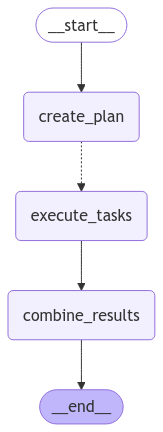

In [245]:
# 그래프 생성
graph = create_graph()

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [168]:
# 초기 상태 설정
initial_state = {
    "query": "blink twice like a star",
    "num_of_leds": 3,
    "tasks": [],
    "results": [],
    "final_result": ""
}

for event in graph.stream(initial_state, config={"verbose": True}):
     print(f"중간 결과: {event}")

중간 결과: {'create_plan': {'tasks': [LedTask(taskid=1, action="set_led(led=1, on=True, brightness=100, color='white')"), LedTask(taskid=2, action='wait(seconds=0.5)'), LedTask(taskid=3, action='set_led(led=1, on=False)'), LedTask(taskid=4, action='wait(seconds=0.5)'), LedTask(taskid=5, action="set_led(led=1, on=True, brightness=100, color='white')"), LedTask(taskid=6, action='wait(seconds=0.5)'), LedTask(taskid=7, action='set_led(led=1, on=False)'), LedTask(taskid=8, action='wait(seconds=0.5)'), LedTask(taskid=9, action='repeat_sequence(times=2)')]}}
중간 결과: {'execute_tasks': {'results': [{'taskid': 2, 'result': None}]}}
중간 결과: {'execute_tasks': {'results': [{'taskid': 6, 'result': None}]}}
중간 결과: {'execute_tasks': {'results': [{'taskid': 3, 'result': LedCommandList(commands=[SetCommand(cmd='set', led_id_from=1, led_id_to=1, color=[0, 0, 0])])}]}}
중간 결과: {'execute_tasks': {'results': [{'taskid': 4, 'result': None}]}}
중간 결과: {'execute_tasks': {'results': [{'taskid': 5, 'result': LedCommandL

In [207]:
# 그래프 실행
result = graph.invoke(initial_state)

result

{'query': 'blink twice like a star',
 'num_of_leds': 3,
 'tasks': [LedTask(taskid=1, action='Turn on all 3 LEDs at full brightness'),
  LedTask(taskid=2, action='Turn off all LEDs'),
  LedTask(taskid=3, action='Turn on all 3 LEDs at full brightness'),
  LedTask(taskid=4, action='Turn off all LEDs'),
  LedTask(taskid=5, action='Repeat tasks 1 through 4 twice to create a blinking effect like a star')],
 'results': [{'taskid': 1,
   'result': LedCommandList(commands=[SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[255, 255, 255]), SleepCommand(cmd='sleep', milis=1000)])},
  {'taskid': 2,
   'result': LedCommandList(commands=[SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[0, 0, 0]), SleepCommand(cmd='sleep', milis=1000)])},
  {'taskid': 3,
   'result': LedCommandList(commands=[SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[255, 255, 255]), SleepCommand(cmd='sleep', milis=1000)])},
  {'taskid': 4,
   'result': LedCommandList(commands=[SetCommand(cmd='set', led_i

In [208]:
led = LedCommandList(commands=[])

for c in result['final_result']:
    led.commands += c['result'].commands

from pprint import pprint
pprint(led.commands)

[SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[255, 255, 255]),
 SleepCommand(cmd='sleep', milis=1000),
 SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[0, 0, 0]),
 SleepCommand(cmd='sleep', milis=1000),
 SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[255, 255, 255]),
 SleepCommand(cmd='sleep', milis=1000),
 SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[0, 0, 0]),
 SleepCommand(cmd='sleep', milis=1000),
 SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[255, 255, 255]),
 SleepCommand(cmd='sleep', milis=1000),
 SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[0, 0, 0]),
 SleepCommand(cmd='sleep', milis=1000),
 SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[255, 255, 255]),
 SleepCommand(cmd='sleep', milis=1000),
 SetCommand(cmd='set', led_id_from=0, led_id_to=2, color=[0, 0, 0]),
 SleepCommand(cmd='sleep', milis=1000),
 RepeatCommand(cmd='repeat', repeat=True)]


In [209]:
led.model_dump_json()

'{"commands":[{"cmd":"set","led_id_from":0,"led_id_to":2,"color":[255,255,255]},{"cmd":"sleep","milis":1000},{"cmd":"set","led_id_from":0,"led_id_to":2,"color":[0,0,0]},{"cmd":"sleep","milis":1000},{"cmd":"set","led_id_from":0,"led_id_to":2,"color":[255,255,255]},{"cmd":"sleep","milis":1000},{"cmd":"set","led_id_from":0,"led_id_to":2,"color":[0,0,0]},{"cmd":"sleep","milis":1000},{"cmd":"set","led_id_from":0,"led_id_to":2,"color":[255,255,255]},{"cmd":"sleep","milis":1000},{"cmd":"set","led_id_from":0,"led_id_to":2,"color":[0,0,0]},{"cmd":"sleep","milis":1000},{"cmd":"set","led_id_from":0,"led_id_to":2,"color":[255,255,255]},{"cmd":"sleep","milis":1000},{"cmd":"set","led_id_from":0,"led_id_to":2,"color":[0,0,0]},{"cmd":"sleep","milis":1000},{"cmd":"repeat","repeat":true}]}'

In [246]:
# 좀 더 복잡한 쿼리를 날려보자

query = "Exciting christmas party with Santa Claus. Santa Claus, dressed in red, walks in while dancing with a green bag. Exciting music and lights continue throughout the party. It would be nice if the color changes slightly and shakes."
initial_state = {
    "query": query,
    "num_of_leds": 30,
    "tasks": [],
    "results": [],
    "final_result": ""
}

result = graph.invoke(initial_state)

result

{'query': 'Exciting christmas party with Santa Claus. Santa Claus, dressed in red, walks in while dancing with a green bag. Exciting music and lights continue throughout the party. It would be nice if the color changes slightly and shakes.',
 'num_of_leds': 30,
 'tasks': [LedTask(taskid=1, action="Turn on all LEDs with a bright red color to represent Santa's suit."),
  LedTask(taskid=2, action="Slowly fade in a green color on a few LEDs to represent Santa's bag."),
  LedTask(taskid=3, action='Make the green LEDs blink rapidly to simulate dancing movements.'),
  LedTask(taskid=4, action='Alternate between red and green colors on all LEDs in a wave-like pattern to create an exciting, festive atmosphere.'),
  LedTask(taskid=5, action='Slightly change the hue of the red and green colors to add variation and make the lights appear to shake.'),
  LedTask(taskid=6, action='Repeat the entire sequence to continue the exciting Christmas party ambiance.')],
 'results': [{'taskid': 1,
   'result':

In [250]:
led = LedCommandList(commands=[])

for c in result['final_result']:
    led.commands += c['result'].commands

from pprint import pprint
pprint(led.commands)

[SetCommand(cmd='set', led_id_from=0, led_id_to=29, color=[255, 0, 0]),
 SleepCommand(cmd='sleep', milis=10000),
 SetCommand(cmd='set', led_id_from=0, led_id_to=29, color=[0, 0, 0]),
 SetCommand(cmd='set', led_id_from=10, led_id_to=15, color=[0, 128, 0]),
 SleepCommand(cmd='sleep', milis=2000),
 SetCommand(cmd='set', led_id_from=10, led_id_to=15, color=[0, 192, 0]),
 SleepCommand(cmd='sleep', milis=2000),
 SetCommand(cmd='set', led_id_from=10, led_id_to=15, color=[0, 255, 0]),
 SleepCommand(cmd='sleep', milis=5000),
 RepeatCommand(cmd='repeat', repeat=False),
 SetCommand(cmd='set', led_id_from=0, led_id_to=29, color=[0, 255, 0]),
 SleepCommand(cmd='sleep', milis=200),
 SetCommand(cmd='set', led_id_from=0, led_id_to=29, color=[0, 0, 0]),
 SleepCommand(cmd='sleep', milis=200),
 RepeatCommand(cmd='repeat', repeat=True),
 SetCommand(cmd='set', led_id_from=0, led_id_to=29, color=[255, 0, 0]),
 SleepCommand(cmd='sleep', milis=500),
 SetCommand(cmd='set', led_id_from=1, led_id_to=28, color=[0